/tmp/ipykernel_22016/458961873.py:60: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df['avg_energy'][ ind:ind+len_in].append(


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.1475        0.1929     +  1.6560
      2        0.1491        0.1935        1.6648
      3        0.1486        0.1935        1.6658
      4        0.1486        0.1935        1.6454
      5        0.1486        0.1935        1.6486


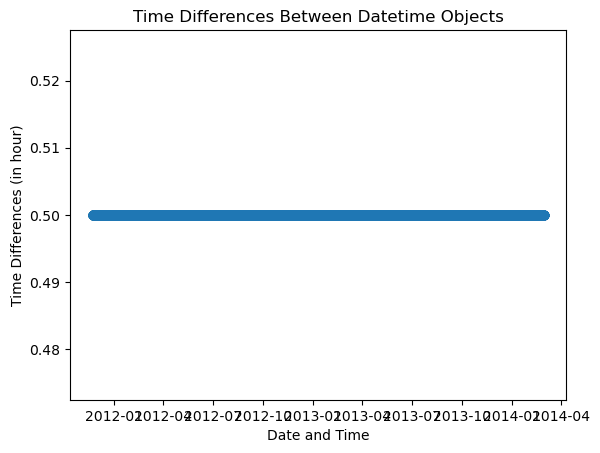

In [45]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import os
from datetime import timedelta
import copy
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import seaborn as sns
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import skorch
import torch
from skorch import helper 
from skorch import NeuralNetRegressor
import matplotlib.pyplot as plt
import torchvision
from skorch.helper import predefined_split
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score
import pytz
utc=pytz.UTC

device = 'cuda' if torch.cuda.is_available() else 'cpu'

len_in  = 25 # number of half hour steps to make the input
len_out = 1  # number of half hour steps to make the input

train_data_stop    = utc.localize(datetime.datetime(2013, 6, 1, 0, 0, 0))
validate_data_stop = utc.localize(datetime.datetime(2014, 1, 1, 0, 0, 0))

data_df = pd.read_csv('../norm_data.csv')
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], utc=True)

# Make datasets 
X_train = []
y_train = []
X_validate = []
y_validate = []
X_test = []
y_test = []
for (ind, date) in enumerate(data_df['timestamp'][:-(len_in+len_out)]):
    X = np.array(
            data_df['avg_energy'][ ind:ind+len_in].append(
            data_df['is_holiday'][ ind:ind+len_in], ignore_index=True).append(
            data_df['visibility'][ ind:ind+len_in], ignore_index=True).append(
            data_df['temperature'][ind:ind+len_in], ignore_index=True).append(
            data_df['dewPoint'][   ind:ind+len_in], ignore_index=True).append(
            data_df['pressure'][   ind:ind+len_in], ignore_index=True).append(
            data_df['windSpeed'][  ind:ind+len_in], ignore_index=True).append(
            data_df['precipType'][ ind:ind+len_in], ignore_index=True).append(
            data_df['humidity'][   ind:ind+len_in], ignore_index=True).append(
            data_df['hour_minute'][ind:ind+len_in], ignore_index=True).append(
            data_df['month'][      ind:ind+len_in], ignore_index=True).append(
            data_df['day'][        ind:ind+len_in], ignore_index=True).append(
            data_df['year'][       ind:ind+len_in], ignore_index=True).append(
            data_df['is_weekday'][ ind:ind+len_in], ignore_index=True),
        dtype=float,
    )
    y = np.array(data_df['avg_energy'][ind+len_in:ind+len_in+len_out], dtype=float)
    if date < train_data_stop:
        X_train.append(X)
        y_train.append(y)
    elif date < validate_data_stop:
        X_validate.append(X)
        y_validate.append(y)
    else:
        X_test.append(X)
        y_test.append(y)
        break ######
X_train    = torch.from_numpy(np.array(X_train)).   float()
y_train    = torch.from_numpy(np.array(y_train)).   float()
X_validate = torch.from_numpy(np.array(X_validate)).float()
y_validate = torch.from_numpy(np.array(y_validate)).float()
X_test     = torch.from_numpy(np.array(X_test)).    float()
y_test     = torch.from_numpy(np.array(y_test)).    float()

# Define network 
class FullConnected(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()

        self.layers = [nn.Linear(input_dim, hidden_dims[0])]
        prev_size = input_dim
        for i in range(len(hidden_dims)-1):
            self.layers.append(nn.Linear(prev_size+hidden_dims[i], hidden_dims[i+1]))
            prev_size += hidden_dims[i]
        self.layers.append(nn.Linear(prev_size+hidden_dims[-1], output_dim))
        self.classifier = nn.ModuleList(self.layers)
        
        self.nl = nn.Sigmoid()

    def forward(self, x):
        for (i, l) in enumerate(self.classifier):
            if i == len(self.classifier)-1:
                x = self.nl(l(x))
            else:
                x = torch.cat((x, self.nl(l(x))), dim=1)
        return x

# Train
model = NeuralNetRegressor(module = FullConnected, 
                           module__input_dim = 14*len_in,
                           module__hidden_dims = [1000,1000,1000,1000,1000,1000],
                           module__output_dim = len_out,
                           max_epochs = 100, 
                           criterion = torch.nn.MSELoss, 
                           optimizer = torch.optim.SGD,
                           lr = 0.1,
                           batch_size = 256,
                           device = device,
                           callbacks=[skorch.callbacks.EarlyStopping(patience=5)], 
                                      #skorch.callbacks.Checkpoint(monitor='valid_loss_best')],
                           train_split=predefined_split(skorch.dataset.Dataset(X_validate, y_validate)),
                           verbose = 1,
                           iterator_train__num_workers = 2,
                           iterator_train__pin_memory = True,
                           iterator_valid__num_workers = 2,
                           iterator_valid__pin_memory = True)
model.fit(X_train, y_train)


## Calculate time differences
time_diffs = [(data_df['timestamp'][i] - data_df['timestamp'][i - 1]).total_seconds() / 60 / 60 for i in range(1, len(data_df['timestamp']))]
## Plotting
plt.plot(data_df['timestamp'][1:], time_diffs, marker='o', linestyle='-')
plt.xlabel('Date and Time')
plt.ylabel('Time Differences (in hour)')
plt.title('Time Differences Between Datetime Objects')
plt.show()


In [13]:
raise

import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import os
from datetime import timedelta
import copy
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def PrecipTypeToVal(precip_type):
    if precip_type == 'rain':
        return 0
    elif precip_type == 'snow':
        return 1
    else:
        raise RuntimeError('that is not a good precip type')
    
def ValToPrecipType(precip_type):
    if precip_type == 0:
        return 'rain'
    elif precip_type == 1:
        return 'snow'
    else:
        raise RuntimeError('that is not a good precip type value')

def getData(data_dir = '../data/'):
    # Load data 
    holidays_df       = pd.read_csv(data_dir + 'uk_bank_holidays.csv')
    weather_hourly_df = pd.read_csv(data_dir + 'weather_hourly_darksky.csv')
    by_meter_df       = pd.read_csv(data_dir + 'informations_households.csv')

    half_hour_power_df = pd.read_csv(data_dir + "halfhourly_dataset/halfhourly_dataset/block_0.csv")
    for block_it in range(1,112):
        half_hour_power_block = pd.read_csv(data_dir + "halfhourly_dataset/halfhourly_dataset/block_" + str(block_it) + ".csv")
        half_hour_power_df = pd.concat([half_hour_power_block], ignore_index=True)
    holidays_df = holidays_df.drop('Type', axis=1)
    holidays_df['Bank holidays'] = pd.to_datetime(holidays_df['Bank holidays'], format='%Y-%m-%d', utc=True)
    weather_hourly_df = weather_hourly_df.rename(columns={"time": "timestamp"})
    weather_hourly_df = weather_hourly_df.drop(['icon', 'windBearing', 'apparentTemperature', 'summary'], axis=1)
    weather_hourly_df['timestamp'] = pd.to_datetime(weather_hourly_df['timestamp'], utc=True)
    by_meter_df = by_meter_df.drop(['stdorToU', 'Acorn', 'file'], axis=1)
    half_hour_power_df = half_hour_power_df.rename(columns={"tstp": "timestamp"})
    half_hour_power_df['timestamp'] = pd.to_datetime(half_hour_power_df['timestamp'], utc=True)
    half_hour_power_df = half_hour_power_df[half_hour_power_df['energy(kWh/hh)'] != 'Null']
    half_hour_power_df['energy(kWh/hh)'] = half_hour_power_df['energy(kWh/hh)'].astype('float')

    # Get time vec
    weather_hourly_df = weather_hourly_df.sort_values(by='timestamp')
    start_time = weather_hourly_df['timestamp'].iloc[0]
    end_time = weather_hourly_df['timestamp'].iloc[-1]
    iterated_time = start_time + timedelta(minutes=30)
    all_needed_times = [copy.deepcopy(iterated_time)]
    while iterated_time < end_time:
        iterated_time = iterated_time + timedelta(minutes=30)
        all_needed_times.append(copy.deepcopy(iterated_time))
    time_df = pd.DataFrame({'timestamp': all_needed_times})

    # Interpolate weather data
    weather_half_hour_df = pd.merge(time_df, weather_hourly_df, on='timestamp', how='left')
    weather_half_hour_df.sort_values(by='timestamp', inplace=True)
    weather_half_hour_df['precipType'].fillna(method='ffill', inplace=True)
    weather_half_hour_df['precipType'].fillna(method='bfill', inplace=True)
    for col_it in ['temperature', 'dewPoint', 'pressure', 'windSpeed', 'humidity', 'visibility']:
        weather_half_hour_df[col_it].interpolate(method='quadratic', inplace=True)
        weather_half_hour_df[col_it].fillna(method='ffill', inplace=True)
        weather_half_hour_df[col_it].fillna(method='bfill', inplace=True)

    # Replace precipType with index values
    weather_half_hour_df['precipType'] = weather_half_hour_df['precipType'].apply(lambda x: PrecipTypeToVal(x))

    # Add holidays 
    weather_half_hour_df = weather_half_hour_df.merge(holidays_df, left_on = 'timestamp', right_on = 'Bank holidays', how = 'left')
    weather_half_hour_df['Bank holidays'] = np.where(weather_half_hour_df['Bank holidays'].isna(), 0, 1)

    # Put it all together
    housecount   = half_hour_power_df.groupby('timestamp')[['LCLid']].nunique().sort_values(by='timestamp').astype('float')
    total_energy = half_hour_power_df.groupby('timestamp')[['energy(kWh/hh)']].sum().sort_values(by='timestamp').astype('float')

    weather_half_hour_df = pd.merge(housecount, weather_half_hour_df, on='timestamp', how='left')
    weather_half_hour_df = weather_half_hour_df.rename(columns={"LCLid": "num_houses"})
    
    weather_half_hour_df = pd.merge(total_energy, weather_half_hour_df, on='timestamp', how='left')
    weather_half_hour_df = weather_half_hour_df.rename(columns={"energy(kWh/hh)": "total_energy"})
    
    weather_half_hour_df.sort_values(by='timestamp', inplace=True)


    output = pd.DataFrame(data={'timestamp': weather_half_hour_df['timestamp'],
                                'avg_energy': weather_half_hour_df['total_energy'] / weather_half_hour_df['num_houses'],
                                'num_houses': weather_half_hour_df['num_houses'],
                                'is_holiday': weather_half_hour_df['Bank holidays'],
                                'visibility': weather_half_hour_df['visibility'],
                                'temperature': weather_half_hour_df['temperature'],
                                'dewPoint': weather_half_hour_df['dewPoint'],
                                'pressure': weather_half_hour_df['pressure'],
                                'windSpeed': weather_half_hour_df['windSpeed'],
                                'precipType': weather_half_hour_df['precipType'],
                                'humidity': weather_half_hour_df['humidity']})
    output.dropna(axis=0, inplace=True)

    # Normalize 
    normalization_cols = [i for i in output.columns.tolist() if i not in ['timestamp', 'precipType', 'num_houses', 'is_holiday']]
    normalization_vals = {}
    for col_name in normalization_cols:
        normalization_vals[col_name] = {}
        normalization_vals[col_name]['min'] = output[col_name].min()
        normalization_vals[col_name]['max'] = output[col_name].max()
        normalization_vals[col_name]['std'] = output[col_name].std()
    normalizer = MinMaxScaler(feature_range=(0, 1))
    output[normalization_cols] = normalizer.fit_transform(output[normalization_cols])

    return output, normalization_vals

RuntimeError: No active exception to reraise

In [ ]:
df, _ = getData()
df.to_csv(path_or_buf="../normalized_data.csv")

: 